#라이브러리 및 환경설정

In [1]:
from google.colab import drive
drive.mount('/content/drive')
import os
import sys

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# 필요한 라이브러리와 해당 버전을 적어둔 txt 파일을 읽어오고 해당 라이브러리들을 설치
!pip install -r "/content/drive/Shareddrives/braille/model/PyTorch/requirements.txt"
# 이미지 전환을 해주는 라이브러리로 object detection task에서 이미지를 transform 적용하면 바운딩 박스도 함께 transform 되도록 해줌
!pip install albumentations==0.4.6

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
from google.colab.patches import cv2_imshow
import cv2
from numpy.fft import fft2, ifft2
from scipy.signal import gaussian, convolve2d

In [4]:
# 필요한 라이브러리 불러오기
import collections
import pandas as pd
import numpy as np
import functools
import matplotlib.pyplot as plt
import cv2

from sklearn import preprocessing 
from tqdm import tqdm

import xml.etree.ElementTree as ET

import albumentations as A
from albumentations.pytorch import ToTensorV2

import torch
import torchvision

from torchvision import transforms
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch import nn
from torch import optim

import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset
from torch.utils.data import random_split
from torch.utils.data import SequentialSampler
from torch.utils.tensorboard import SummaryWriter

import random

In [5]:
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-29k1jkl_
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-29k1jkl_
  Created wheel for pycocotools: filename=pycocotools-2.0-cp37-cp37m-linux_x86_64.whl size=265174 sha256=783ce8a7289dbbaad42562298bf1633d206fc52e8478612ef8a557f2ab0ea576
  Stored in directory: /tmp/pip-ephem-wheel-cache-uv7ptvnl/wheels/e2/6b/1d/344ac773c7495ea0b85eb228bc66daec7400a143a92d36b7b1
Successfully built pycocotools
  Attempting uninstall: pycocotools
    Found existing installation: pycocotools 2.0.4
    Uninstalling pycocotools-2.0.4:
      Successfully uninstalled pycocotools-2.0.4


In [6]:
!git clone https://github.com/pytorch/vision.git
!cd vision;cp references/detection/utils.py ../;cp references/detection/transforms.py ../;cp references/detection/coco_eval.py ../;cp references/detection/engine.py ../;cp references/detection/coco_utils.py ../

Cloning into 'vision'...
remote: Enumerating objects: 155343, done.
remote: Counting objects: 100% (7716/7716), done.
remote: Compressing objects: 100% (667/667), done.
remote: Total 155343 (delta 7100), reused 7571 (delta 7017), pack-reused 147627
Receiving objects: 100% (155343/155343), 304.88 MiB | 27.99 MiB/s, done.
Resolving deltas: 100% (137693/137693), done.


In [7]:
from engine import train_one_epoch, evaluate
import utils

In [8]:
classes = {1: 'a', 2: 'b', 25: 'y', 24: 'x', 23: 'w', 22: 'v', 21: 'u', 20: 't', 19: 's', 18: 'r', 17: 'q', 16: 'p', 15: 'o', 14: 'n', 13: 'm', 12: 'l', 11: 'k', 10: 'j', 9: 'i', 8: 'h', 6: 'f', 5: 'e', 4: 'd', 3: 'c', 26: 'z', 7: 'g'}

#이미지 전처리

In [23]:
def image_pretreatment(image):
    image1 = cv2.imread(image, 0)
    clahe = cv2.createCLAHE(clipLimit=1.0, tileGridSize=(4,4))
    img = clahe.apply(image1)
    # 가우시안 블러링
    kernel = np.array([[0, -1, 0],
                   [-1, 5,-1],
                   [0, -1, 0]]) 
    # 이미지를 선명하게
    image_sharp = cv2.filter2D(img, -1, kernel)
    blur = cv2.GaussianBlur(image_sharp, (3, 3), 0)
    # 이진화
    th = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 71, 12)
    # 이미지 비트 연산
    th_not = cv2.bitwise_not(th)
    # median 블러 = smoothing
    img_gray_blur = cv2.medianBlur(th_not, 5)
    # kernel 생성
    kernel_erode = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    kernel_dilate = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    # 침식
    # erode = cv2.erode(img_gray_blur2, kernel_erode)
    # 팽창
    dilate = cv2.dilate(img_gray_blur, kernel_dilate)
    erode = cv2.erode(dilate, kernel_erode)
    # 다시 median 필터로 출력
    img_gray = cv2.medianBlur(erode, 3)
    imgs = {'original':image1, 'hist':img, 'image_sharp':image_sharp,# 'clahe':img,
            'th_not':th_not, 'img_gray_blur':img_gray_blur, #'img_gray_blur2':img_gray_blur2,
            'dilate':dilate, 'erode':erode, 'result':img_gray} #'result2':img_gray}
    return imgs

In [24]:
pred_path = "/content/drive/Shareddrives/braille/data/data/image"
pred_files = [os.path.join(pred_path,f) for f in os.listdir(pred_path)]
file_names = [f for f in os.listdir(pred_path)]
final_test_images = []
for i, images in enumerate(pred_files):
    if i == 0:
      imgs = image_pretreatment(images)
      cv2.imwrite('/content/result.jpeg',imgs['result'])
    else:
      break

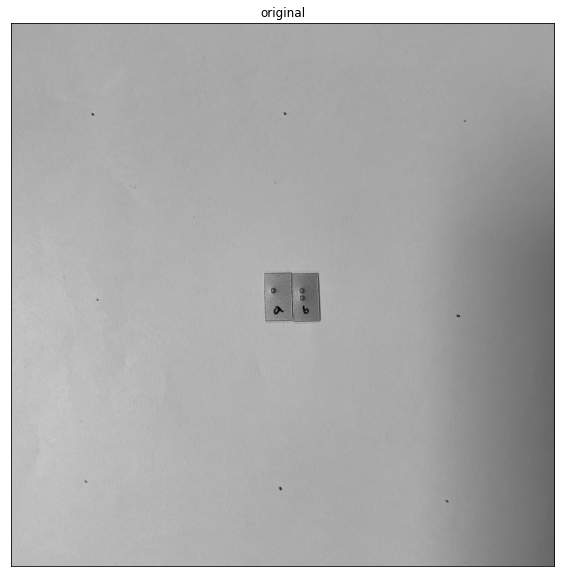

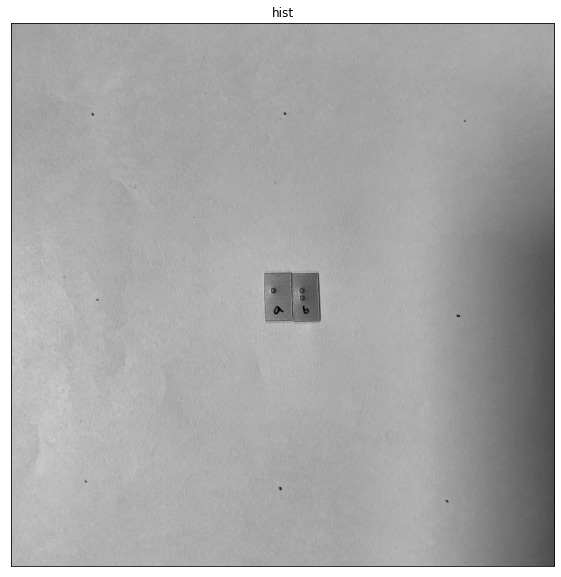

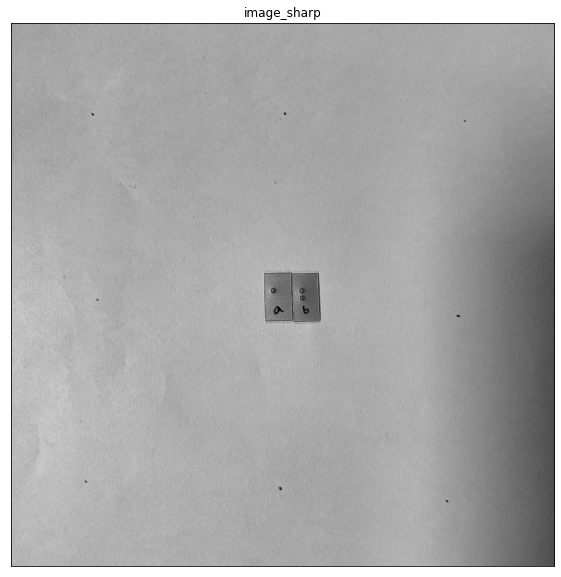

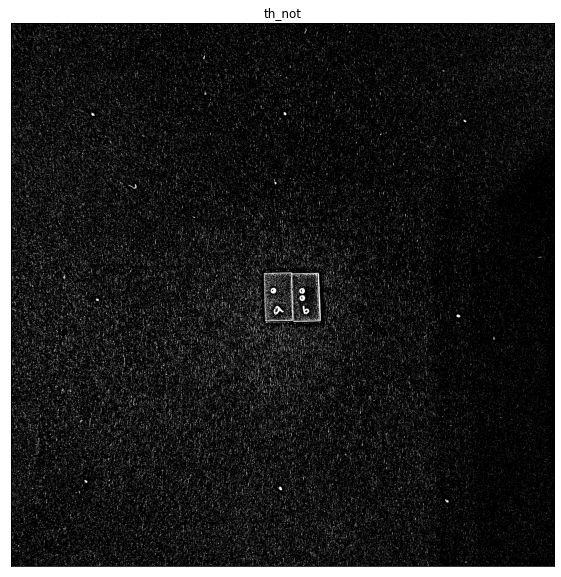

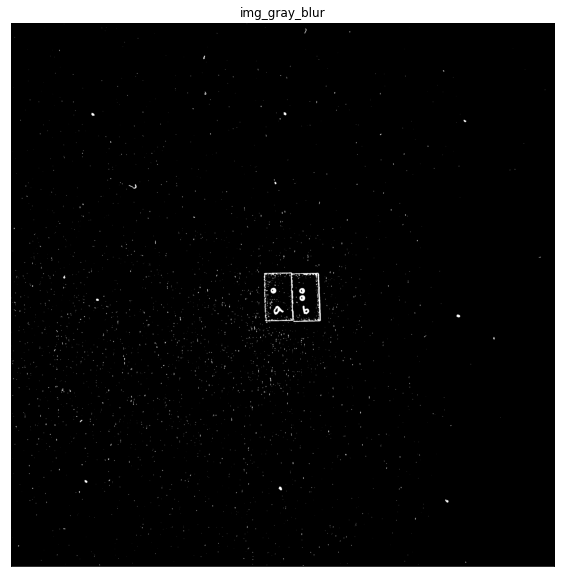

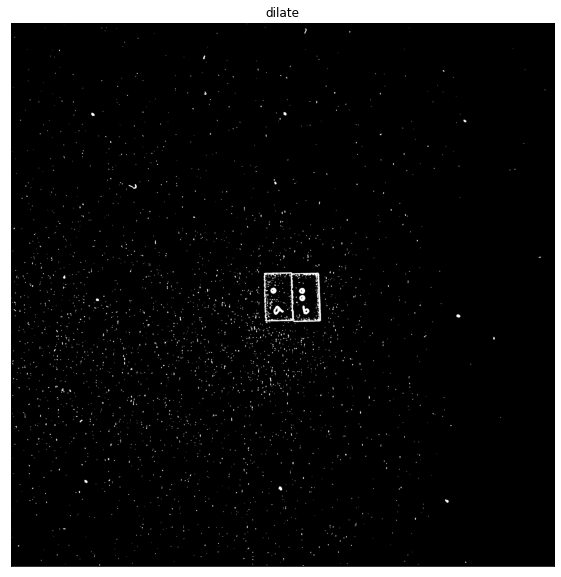

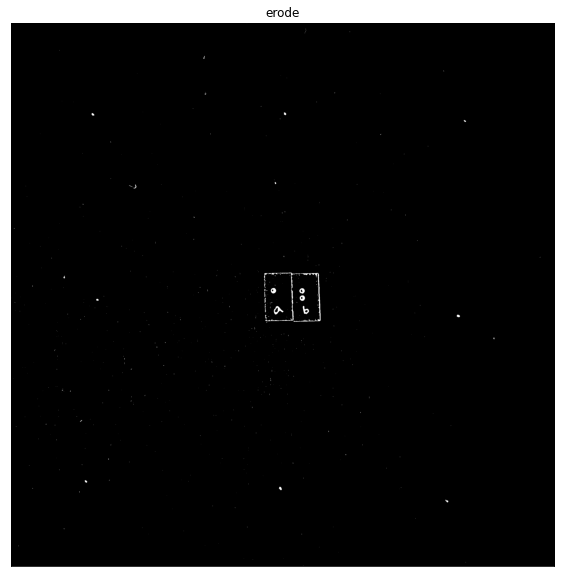

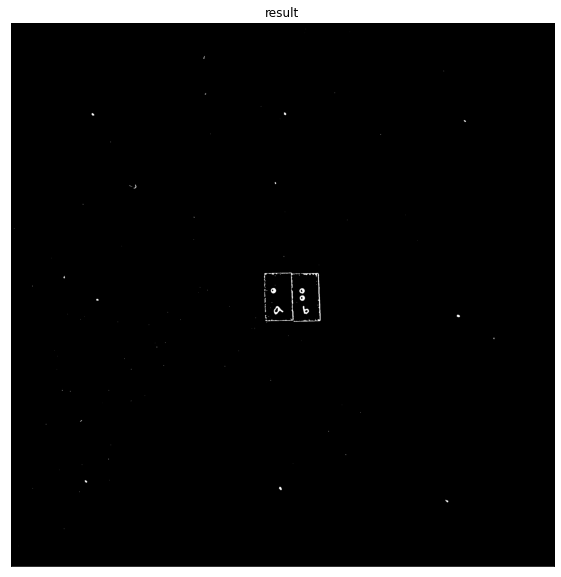

In [11]:
for i, (key, value) in enumerate(imgs.items()):
    plt.figure(figsize=(10,10))
    plt.title(key)
    plt.imshow(value, cmap='gray')
    plt.xticks([]);    plt.yticks([])
    plt.plot()

#모델 불러오기

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [13]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False, pretrained_backbone=False)
WEIGHTS_FILE = "/content/drive/Shareddrives/braille/param/new_pre_model_45epoch.pth"
num_classes = 36
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
# Load the traines weights
model.load_state_dict(torch.load(WEIGHTS_FILE))
model = model.to(device)

#이미지에서 결과 확인

In [25]:
def obj_detector(img):
    img = cv2.imread(img, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)


    img /= 255.0
    img = torch.from_numpy(img)
    img = img.unsqueeze(0)
    img = img.permute(0,3,1,2)
    
    model.eval()

    detection_threshold = 0.6
    
    img = list(im.to(device) for im in img)
    output = model(img)

    for i , im in enumerate(img):
        boxes = output[i]['boxes'].data.cpu().numpy()
        scores = output[i]['scores'].data.cpu().numpy()
        labels = output[i]['labels'].data.cpu().numpy()

        labels = labels[scores >= detection_threshold]
        boxes = boxes[scores >= detection_threshold].astype(np.int32)
        scores = scores[scores >= detection_threshold]

        boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
        boxes[:, 3] = boxes[:, 3] - boxes[:, 1]
    
    sample = img[0].permute(1,2,0).cpu().numpy()
    sample = np.array(sample)
    boxes = output[0]['boxes'].data.cpu().numpy()
    name = output[0]['labels'].data.cpu().numpy()
    scores = output[0]['scores'].data.cpu().numpy()
    boxes = boxes[scores >= detection_threshold].astype(np.int32)
    names = name.tolist()
    
    return names, boxes, sample

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


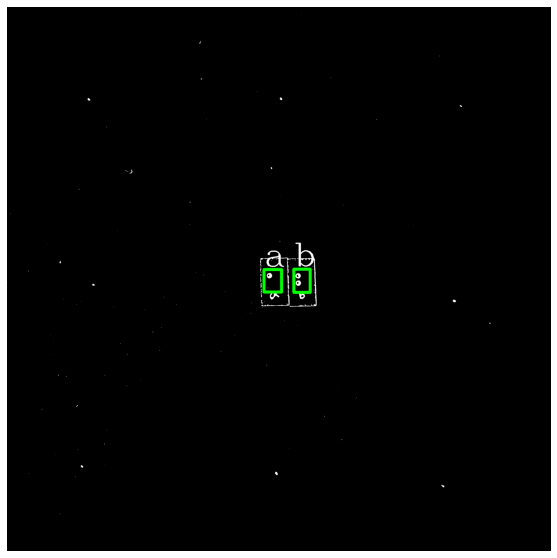

In [27]:
plt.figure(figsize=(10,10))
names, boxes, sample = obj_detector('/content/result.jpeg')
for i,box in enumerate(boxes):
  cv2.rectangle(sample,
                (box[0], box[1]),
                (box[2], box[3]),
                (0, 220, 0), 15)
  cv2.putText(sample, str(classes[names[i]]), (box[0],box[1]-18),cv2.FONT_HERSHEY_COMPLEX ,6,(255,255,255),6,cv2.LINE_AA)  
plt.axis('off')
plt.imshow(sample)
plt.savefig('save_image.png', bbox_inches='tight')  # if you want to save result

#다른 데이터에 대한 결과 확인

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


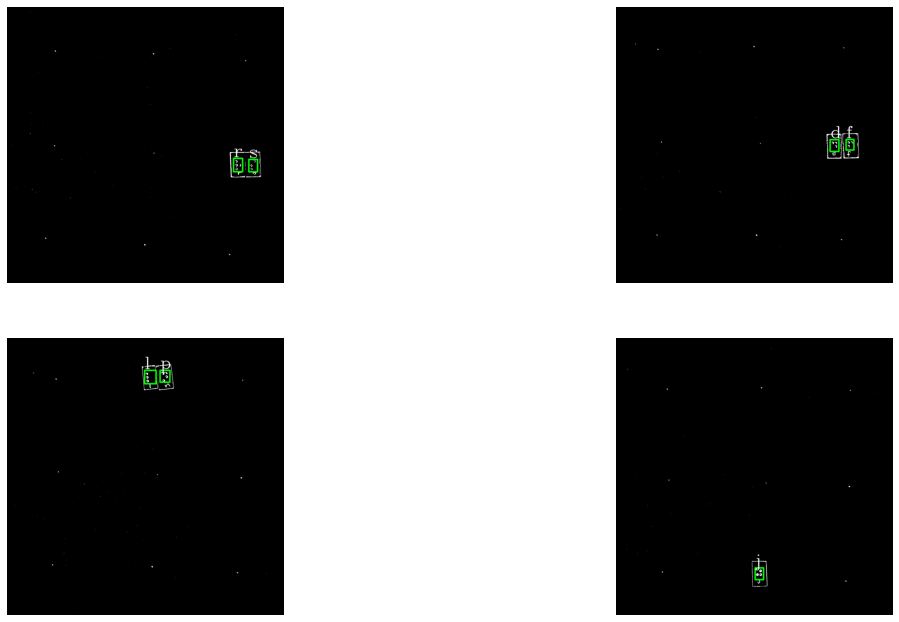

In [28]:
import random

pred_path = "/content/drive/Shareddrives/braille/data/data/pre_image"
pred_files = [os.path.join(pred_path,f) for f in os.listdir(pred_path)]

pred_files = random.sample(pred_files, 4)

plt.figure(figsize=(20,60))
for i, images in enumerate(pred_files):
    if i > 6: break
    plt.subplot(10,2,i+1)
    names,boxes,sample = obj_detector(images)
    for i,box in enumerate(boxes):
        cv2.rectangle(sample,
                      (box[0], box[1]),
                      (box[2], box[3]),
                      (0, 220, 0), 15)
        cv2.putText(sample, str(classes[names[i]]), (box[0],box[1]-18),cv2.FONT_HERSHEY_COMPLEX ,6,(255,255,255),6,cv2.LINE_AA)  

    plt.axis('off')
    plt.imshow(sample)
    plt.savefig('save_image.png', bbox_inches='tight')  # if you want to save result